<a href="https://colab.research.google.com/github/canneltigrou/canneltigrou.github.io/blob/master/JupyterNotebooks/M2_RFA_CCTP_2018_etudiant_CnnOnVocalClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrôle de TP M2 IARF-Rodeco

**Auteurs :** Benjamin Chamand - Thomas Pellegrini

**Année :** 2018-2019

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquements de feu, tic-tac d'une horloge, le bruit d'un coq, etc...).

Les fichiers audio sont convertis en spectrogramme, une représentation temps/fréquence du signal qui peut être vue comme une image.

**La méthodologie reste la même et ne change absolument pas par rapport aux séances précédentes ! Toutes les méthodes vues durant les séances précédentes peuvent donc être réapliquées ici.**

## Gestion des pré-requis avant de commencer le contrôle

__Afin de ne pas perdre du temps sur les exécutions de chaque cellule du notebook, vous pouvez tout exécuter en allant dans le menu *Exécution* puis *Tout exécuter*__

### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [ ]:
import os
import random
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [ ]:
!pip install librosa
import librosa
import librosa.display

Vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [ ]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4044703748996417172
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17902087068961803656
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9404769258946806207
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3609727049454753137
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Fixer la seed

On fixe la seed afin de retrouver les mêmes résultats à chaque lancement du programme.

In [ ]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

from tensorflow import random
random.set_seed(1234)

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classifier les différents fichiers audio suivant les 10 classes.

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [ ]:
!wget -O dataset.zip https://www.irit.fr/filez/reyxjnc/download
#!unzip -qq dataset.zip -d data/
#!rm dataset.zip

--2020-08-24 09:17:59--  https://www.irit.fr/filez/reyxjnc/download
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.irit.fr/migration/fin.php?nom=filez [following]
--2020-08-24 09:18:00--  https://www.irit.fr/migration/fin.php?nom=filez
Reusing existing connection to www.irit.fr:443.
HTTP request sent, awaiting response... 200 OK
Length: 3683 (3.6K) [text/html]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   3.60K  --.-KB/s    in 0.004s  

2020-08-24 09:18:00 (825 KB/s) - ‘dataset.zip’ saved [3683/3683]



La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [ ]:
!rm dataset.zip

In [ ]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0))
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [ ]:
# Le chargement des données est assez long : un peu moins de 2min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage


FileNotFoundError: ignored

#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [ ]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[79] = 2 -> crackling_fire
• y_train[191] = 5 -> helicopter
• y_train[225] = 7 -> rooster
• y_train[155] = 4 -> dog
• y_train[92] = 2 -> crackling_fire
• y_train[75] = 2 -> crackling_fire
• y_train[73] = 2 -> crackling_fire
• y_train[295] = 9 -> sneezing
• y_train[39] = 1 -> clock_tick
• y_train[307] = 9 -> sneezing


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

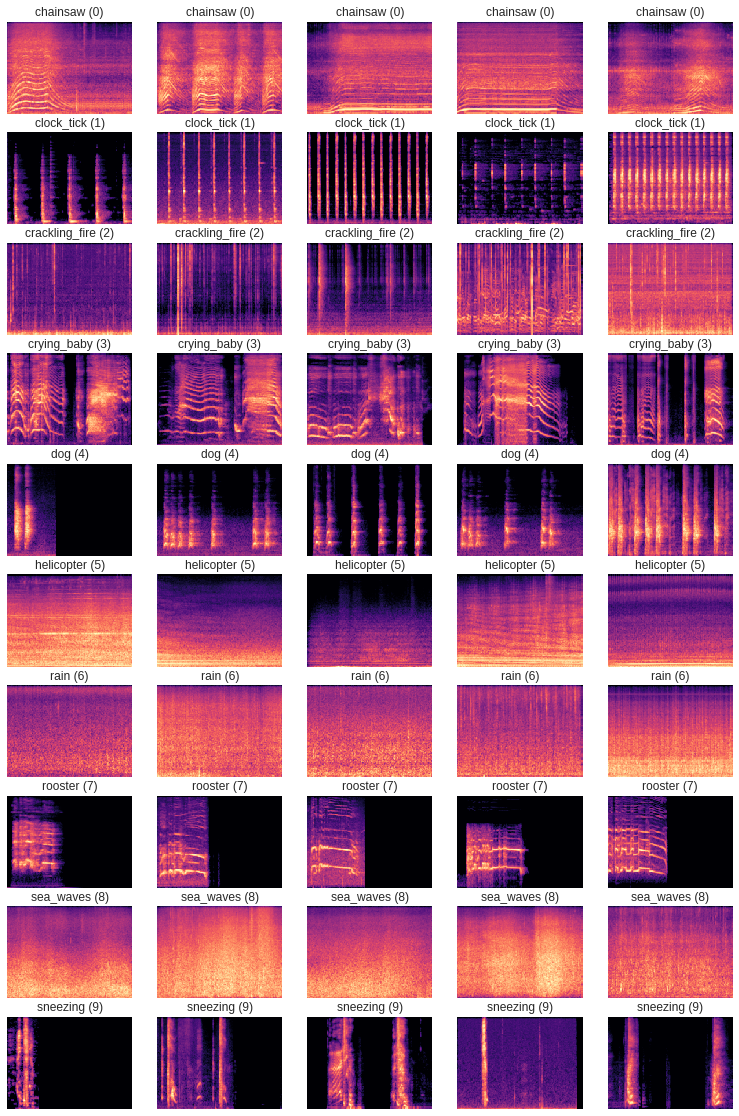

In [ ]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devriez :
* faire attention au format des données en entrée (reshape des images, transformer un vecteur en one hot encoding, etc.) ;
* déclarer l'architecture ;
* compiler le modèle ;
* lancer l'apprentissage ;
* évaluer le modèle ;
* lancer la prédiction sur quelques images de tests.

Pour l'évalutation du modèle, nous utiliserons nos données de tests ce qui n'est normalement pas rigoureux.

#### Prétraitements utilisés sur les deux (MLP et CNN)

In [ ]:
nb_classes = 10

# one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# affichage de l'encodage des labels sur les 10 premières données
# du corpus d'apprentissage
print("Affichage de l'encodage des labels :")
for i in range(10):
    print('• y_train[' + str(i) + '] =', y_train[i], '->', Y_train[i])

Affichage de l'encodage des labels :
• y_train[0] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[1] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[2] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[3] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[4] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[5] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[6] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[7] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[8] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
• y_train[9] = 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# définition de la standardisation
def standardisation(X_train, X_test):
    avg = np.mean(X_train)
    std = np.std(X_train) # standard deviation == ecart-type
    X_train = (X_train - avg) / std
    X_test = (X_test - avg) / std
    return X_train, X_test

X_train, X_test = standardisation(x_train, x_test)

print(X_train.shape)
print(X_test.shape)

(320, 128, 216)
(80, 128, 216)


### Réseau MLP

Dans cette section, vous allez devoir implémenter un réseau dense à 1 ou plusieurs couches cachées

#### Pretraitements

In [ ]:
def img_reshape(X_train, X_test):
    X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
    X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])
    return X_train, X_test

X_train2, X_test2 = img_reshape(X_train, X_test)

print('\nTaille des données :')
print('\t• X_train :', X_train2.shape)
print('\t• X_test :', X_test2.shape)



Taille des données :
	• X_train : (320, 27648)
	• X_test : (80, 27648)


#### Définition du modèle + compilation

In [ ]:
model = Sequential

#couche cachée de 50 neurones.
# Pour le construire, ajouter une couche Dense. 
# Attention vous devez préciser la dimension des inputs pour cette première couche :
model.add(Dense(784, input_dim=X_train2.shape[1]))

# Ensuite ajouter une activation de type ReLu :
model.add(Activation('relu'))

# Ajouter maintenant la couche de sortie avec le bon nombre de neurones et la bonne fonction d'activation :
model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Adagrad(0.003)
# Compile
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

# Affichage des informations sur le réseau défini au-dessus
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               21676816  
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 21,684,666
Trainable params: 21,684,666
Non-trainable params: 0
_________________________________________________________________


#### Apprentissage

In [ ]:
%%time
epochs = 42

# compléter les arguments nécessaires ci-dessous
history = model.fit(X_train2, Y_train, epochs=epochs, batch_size=32)

Epoch 1/42
320/320 [==============================] - 1s 3ms/step - loss: 11.7456 - acc: 0.1719
Epoch 2/42
320/320 [==============================] - 0s 852us/step - loss: 11.0441 - acc: 0.2719
Epoch 3/42
320/320 [==============================] - 0s 802us/step - loss: 9.7339 - acc: 0.3156
Epoch 4/42
320/320 [==============================] - 0s 795us/step - loss: 6.4856 - acc: 0.4625
Epoch 5/42
320/320 [==============================] - 0s 806us/step - loss: 3.7208 - acc: 0.5687
Epoch 6/42
320/320 [==============================] - 0s 788us/step - loss: 2.9401 - acc: 0.6406
Epoch 7/42
320/320 [==============================] - 0s 843us/step - loss: 2.6366 - acc: 0.7281
Epoch 8/42
320/320 [==============================] - 0s 836us/step - loss: 2.6130 - acc: 0.7094
Epoch 9/42
320/320 [==============================] - 0s 815us/step - loss: 2.4964 - acc: 0.7531
Epoch 10/42
320/320 [==============================] - 0s 804us/step - loss: 2.4702 - acc: 0.7469
Epoch 11/42
320/320 [========

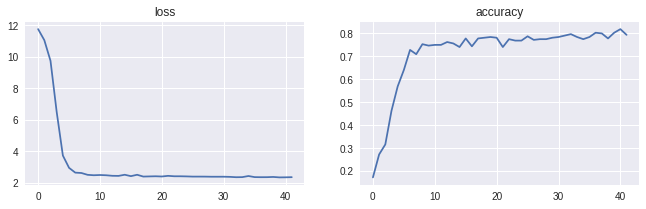

In [ ]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

#### Evaluation

In [ ]:
%%time
scores = model.evaluate(X_test2, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 37.50%
CPU times: user 40 ms, sys: 7.3 ms, total: 47.3 ms
Wall time: 45.9 ms


#### Prédictions

80/80 [==============================] - 0s 493us/step
Confusion matrix (rows: true classes; columns: predicted classes):

[[1 0 0 0 0 4 1 0 2 0]
 [0 6 0 0 0 0 2 0 0 0]
 [0 4 1 0 0 0 3 0 0 0]
 [0 4 0 1 0 0 1 1 0 1]
 [0 2 0 0 1 0 2 0 3 0]
 [0 0 0 0 0 4 4 0 0 0]
 [0 1 0 0 0 0 6 0 1 0]
 [0 2 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 1 3 0 4 0]
 [1 4 0 0 0 0 1 1 1 0]]

Classification accuracy for each class:

0: 0.1250
1: 0.7500
2: 0.1250
3: 0.1250
4: 0.1250
5: 0.5000
6: 0.7500
7: 0.7500
8: 0.5000
9: 0.0000


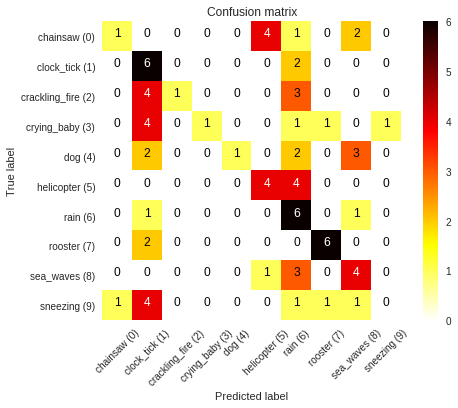

In [ ]:
predictions = model.predict(X_test2, verbose=1)

from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Réseau convolutif

Maintenant, vous allez implémenter un réseau convolutif.

#### Prétraitements CNN (reshape technique)

In [ ]:
# définition des tailles des images
im_width, im_height = 128, 216
n_channels = 1

In [ ]:
def img_reshapeCNN(X_train, X_test):
    X_train = X_train.reshape(-1,X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(-1,X_test.shape[1], X_test.shape[2], 1)
    return X_train, X_test

X_train3, X_test3 = img_reshapeCNN(X_train, X_test)
print(X_train3.shape)
print(X_test3.shape)

(320, 128, 216, 1)
(80, 128, 216, 1)


#### Définition du modèle + compilation

In [ ]:
modelCNN = Sequential()

modelCNN.add(Conv2D(32, (3, 3), input_shape=(im_width, im_height, n_channels)))
modelCNN.add(Activation('tanh'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(64, (3, 3)))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(128, (3, 3)))
modelCNN.add(Activation('tanh'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(256, (3, 3)))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(512))
modelCNN.add(Dropout(0.8))
modelCNN.add(Activation('tanh'))

# classification
modelCNN.add(Dense(10))
modelCNN.add(Activation('softmax'))

optimizer = keras.optimizers.Adagrad(0.003)
# Compile
modelCNN.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

# Affichage des informations sur le réseau défini au-dessus
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 126, 214, 32)      320       
_________________________________________________________________
activation_152 (Activation)  (None, 126, 214, 32)      0         
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 63, 107, 32)       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 61, 105, 64)       18496     
_________________________________________________________________
activation_153 (Activation)  (None, 61, 105, 64)       0         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 30, 52, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 28, 50, 128)       73856     
__________

#### Apprentissage

In [ ]:
%%time
epochs = 100

# compléter les arguments nécessaires ci-dessous
historyCNN = modelCNN.fit(X_train3, Y_train, epochs=epochs, batch_size=32)

Epoch 1/100
320/320 [==============================] - 2s 7ms/step - loss: 2.0491 - acc: 0.2844
Epoch 2/100
320/320 [==============================] - 1s 2ms/step - loss: 1.5884 - acc: 0.4156
Epoch 3/100
320/320 [==============================] - 1s 2ms/step - loss: 1.4202 - acc: 0.4813
Epoch 4/100
320/320 [==============================] - 1s 2ms/step - loss: 1.2883 - acc: 0.5406
Epoch 5/100
320/320 [==============================] - 1s 2ms/step - loss: 1.2067 - acc: 0.6094
Epoch 6/100
320/320 [==============================] - 1s 2ms/step - loss: 1.1443 - acc: 0.6063
Epoch 7/100
320/320 [==============================] - 1s 2ms/step - loss: 1.1134 - acc: 0.6125
Epoch 8/100
320/320 [==============================] - 1s 2ms/step - loss: 1.0516 - acc: 0.6406
Epoch 9/100
320/320 [==============================] - 1s 2ms/step - loss: 0.9472 - acc: 0.7062
Epoch 10/100
320/320 [==============================] - 1s 2ms/step - loss: 0.9552 - acc: 0.6750
Epoch 11/100
320/320 [=================

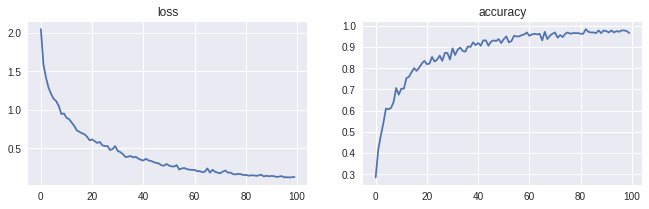

In [ ]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(historyCNN.epoch,historyCNN.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(historyCNN.epoch,historyCNN.history['acc'])
plt.title('accuracy');

#### Evaluation

In [ ]:
%%time
scores = modelCNN.evaluate(X_test3, Y_test, verbose=2)
print("%s: %.2f%%" % (modelCNN.metrics_names[1], scores[1]*100))

acc: 75.00%
CPU times: user 524 ms, sys: 8.14 ms, total: 532 ms
Wall time: 573 ms


#### Prédictions

80/80 [==============================] - 1s 7ms/step
Confusion matrix (rows: true classes; columns: predicted classes):

[[7 0 0 0 0 0 0 0 1 0]
 [0 6 2 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 2 0 0 0]
 [0 1 0 5 1 0 0 1 0 0]
 [0 2 1 0 5 0 0 0 0 0]
 [0 0 0 0 0 4 4 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 1 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 7 1]
 [0 1 0 0 1 0 0 0 0 6]]

Classification accuracy for each class:

chainsaw: 0.8750
clock_tick: 0.7500
crackling_fire: 0.6250
crying_baby: 0.6250
dog: 0.6250
helicopter: 0.5000
rain: 1.0000
rooster: 0.8750
sea_waves: 0.8750
sneezing: 0.7500


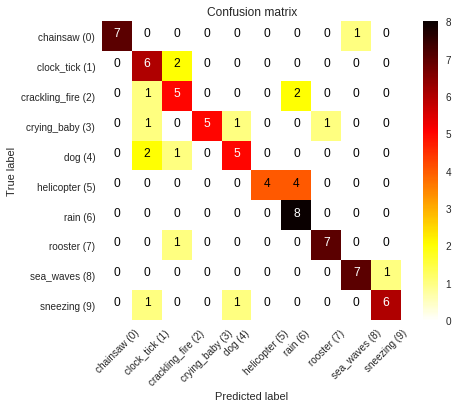

In [ ]:
predictionsCNN = modelCNN.predict(X_test3, verbose=1)

from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictionsCNN, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%s: %.4f" % (idx_to_classes[i],j))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
